# 102 Flower Classification Model using ResNet50 and Tansfer Learning

This notebook builds a classification model using ResNet50 for classifying 102 different types of flowers using transfer learning to fine-tune the model to our dataset.

ref': "https://github.com/lukysummer/Transfer-Learning-with-ResNet50/blob/main/Transfer_Learning_ResNet50_Part1.ipynb"

Step 1: Import Libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, pickle, random, sys
from PIL import Image, ImageFile
import pandas as pd
import seaborn as sns
from collections import OrderedDict, deque, Counter
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import cv2  
from glob import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils import model_zoo
import torch.optim as optim

Step 2: Load the Dataset

In [39]:
train_ids = pd.read_csv(r'C:\Users\Aditya\OneDrive\Desktop\Flower\data\tstid.csv')
valid_ids = pd.read_csv(r'C:\Users\Aditya\OneDrive\Desktop\Flower\data\valid.csv')
test_ids = pd.read_csv(r'C:\Users\Aditya\OneDrive\Desktop\Flower\data\trnid.csv')
labels = pd.read_csv(r'C:\Users\Aditya\OneDrive\Desktop\Flower\data\labels.csv')

In [3]:
print(labels.iloc[6773])

labels    21
Name: 6773, dtype: int64


In [40]:
train_ids.columns = ['image_id']
train_data = train_ids.merge(labels, left_on='image_id', right_index=True)
print(train_data.info())
print(train_data.head())
print(train_data['labels'].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 6148 entries, 0 to 6148
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   image_id  6148 non-null   int64
 1   labels    6148 non-null   int64
dtypes: int64(2)
memory usage: 144.1 KB
None
   image_id  labels
0      6734       1
1      6735       1
2      6737       1
3      6742       1
4      6743       1
102


In [41]:
valid_ids.columns = ['image_id']
valid_data = valid_ids.merge(labels, left_on='image_id', right_index=True)
print(valid_data.info())
print(valid_data.head())
print(valid_data['labels'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   image_id  1020 non-null   int64
 1   labels    1020 non-null   int64
dtypes: int64(2)
memory usage: 16.1 KB
None
   image_id  labels
0      6773      21
1      6767       1
2      6739       1
3      6749       1
4      6763       1
102


In [42]:
test_ids.columns = ['image_id']
test_data = test_ids.merge(labels, left_on='image_id', right_index=True)
print(test_data.info())
print(test_data.head())
print(test_data['labels'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   image_id  1020 non-null   int64
 1   labels    1020 non-null   int64
dtypes: int64(2)
memory usage: 16.1 KB
None
   image_id  labels
0      6765       1
1      6755       1
2      6768       1
3      6736       1
4      6744       1
102


In [43]:
print(train_data['labels'].count())

6148


In [44]:
print(train_data['labels'].value_counts())

labels
51    237
77    230
46    177
73    174
89    164
     ... 
3      20
67     20
45     19
21     19
27     19
Name: count, Length: 102, dtype: int64


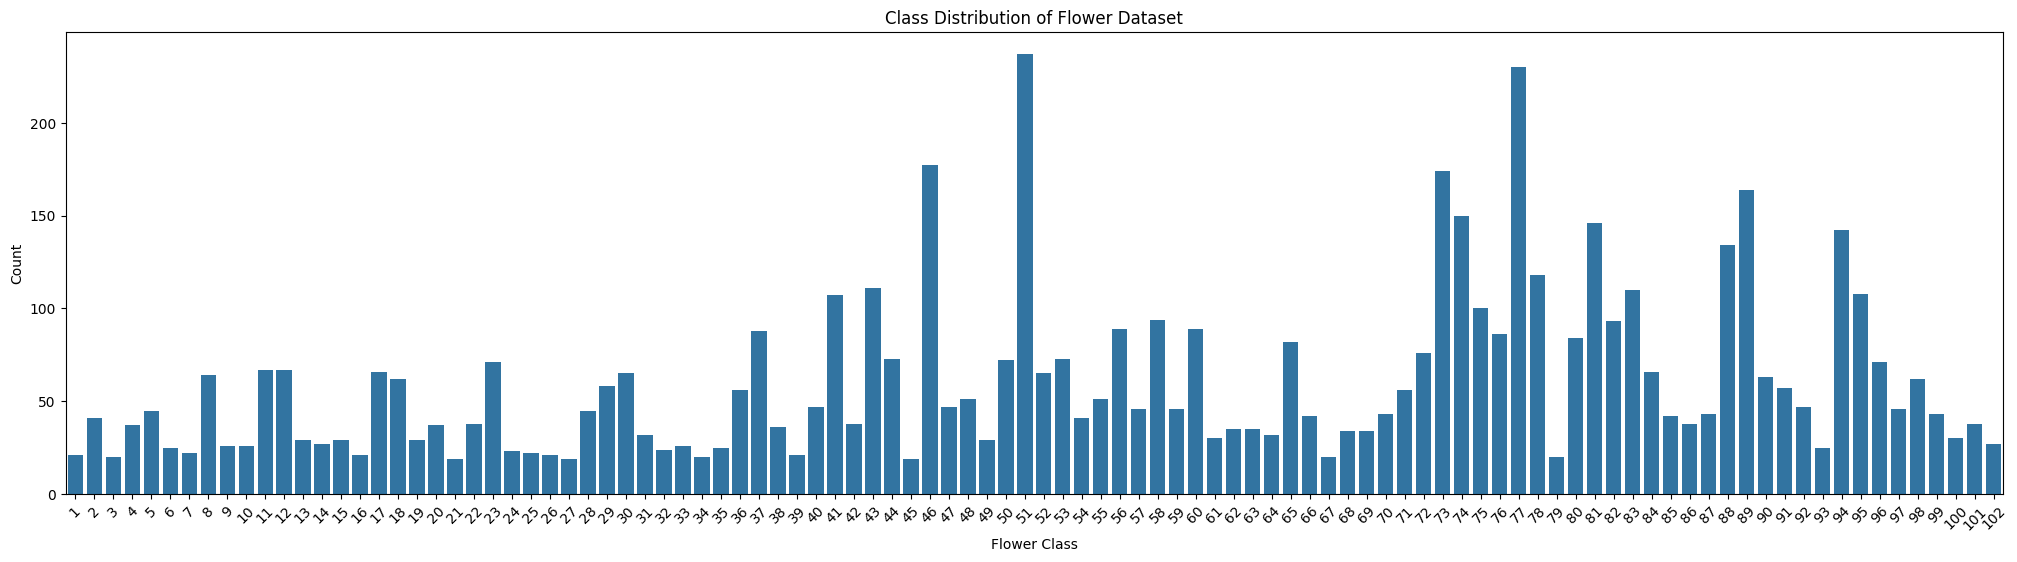

In [45]:
plt.figure(figsize=(25, 6))
sns.countplot(x='labels', data=train_data)
plt.title("Class Distribution of Flower Dataset")
plt.xlabel("Flower Class")
plt.ylabel("Count")
plt.xticks(rotation=45) 
plt.show()

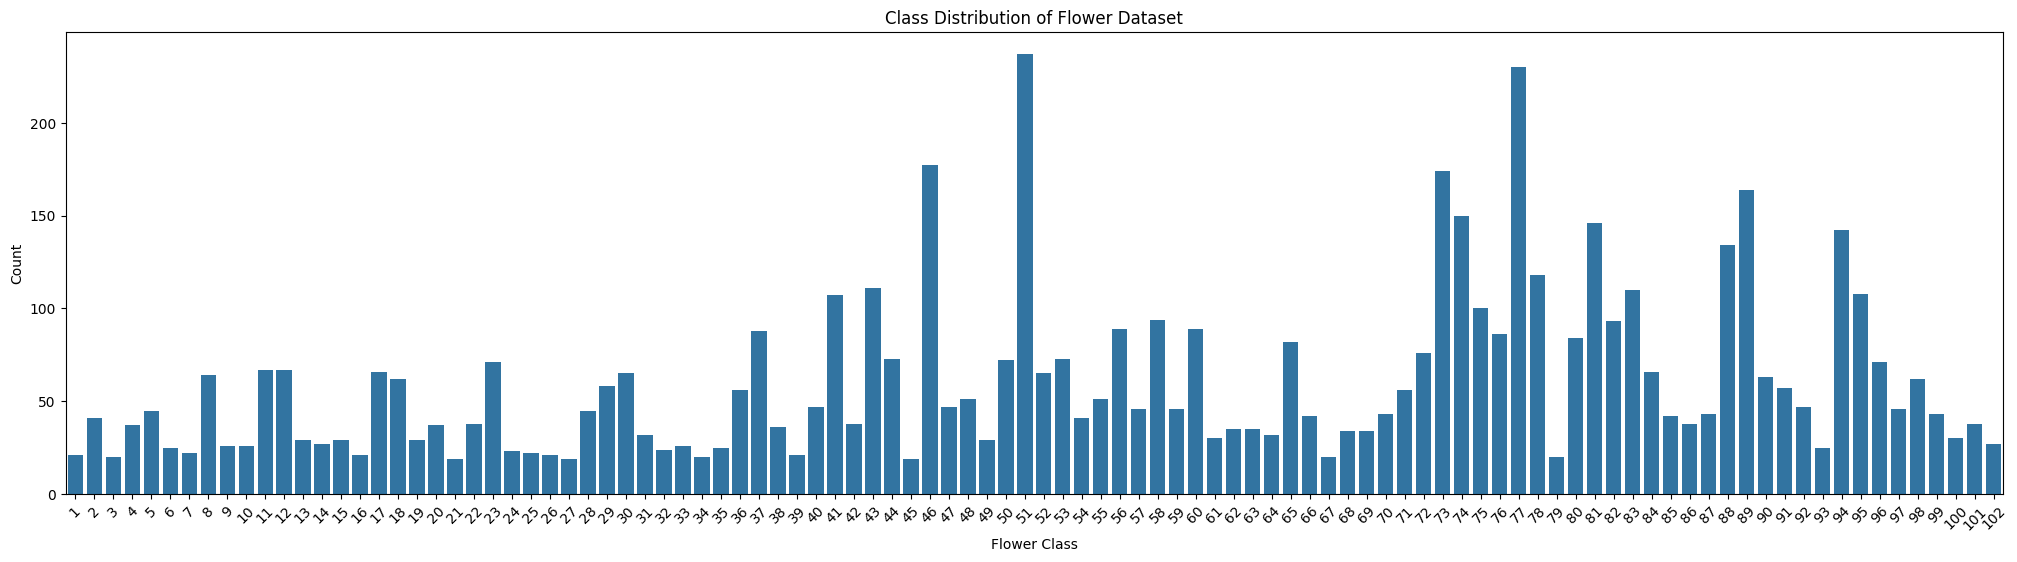

In [46]:
plt.figure(figsize=(25, 6))
sns.countplot(x='labels', data=train_data)
plt.title("Class Distribution of Flower Dataset")
plt.xlabel("Flower Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [48]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['labels']),
    y=train_data['labels']
)
class_weights_dict = dict(enumerate(class_weights))

In [49]:
print(class_weights_dict)

{0: 2.8702147525676938, 1: 1.4701099952175993, 2: 3.0137254901960784, 3: 1.6290408055113939, 4: 1.3394335511982571, 5: 2.410980392156863, 6: 2.7397504456327986, 7: 0.9417892156862745, 8: 2.3182503770739067, 9: 2.3182503770739067, 10: 0.8996195493122622, 11: 0.8996195493122622, 12: 2.0784313725490198, 13: 2.232389251997095, 14: 2.0784313725490198, 15: 2.8702147525676938, 16: 0.9132501485442662, 17: 0.9721695129664769, 18: 2.0784313725490198, 19: 1.6290408055113939, 20: 3.17234262125903, 21: 1.586171310629515, 22: 0.8489367578017122, 23: 2.6206308610400684, 24: 2.7397504456327986, 25: 2.8702147525676938, 26: 3.17234262125903, 27: 1.3394335511982571, 28: 1.0392156862745099, 29: 0.9273001508295626, 30: 1.883578431372549, 31: 2.511437908496732, 32: 2.3182503770739067, 33: 3.0137254901960784, 34: 2.410980392156863, 35: 1.076330532212885, 36: 0.6849376114081996, 37: 1.6742919389978212, 38: 2.8702147525676938, 39: 1.2824363788068418, 40: 0.5633131757375848, 41: 1.586171310629515, 42: 0.5430136

In [11]:

root_dir = "C:/Users/Aditya/OneDrive/Desktop/Flower/data/102flowers"


transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(root_dir + '/train', transform)
valid_data = datasets.ImageFolder(root_dir + '/valid', transform)
test_data = datasets.ImageFolder(root_dir + '/test', transform)


print("Class2idx: ", train_data.class_to_idx)
print('Train images :', len(train_data))
print('Valid images :', len(valid_data))
print('Test images :', len(test_data))


batch_size = 32
dataloaders = {}

dataloaders['train'] = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['valid'] = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = DataLoader(test_data, batch_size=batch_size, shuffle=True)


Class2idx:  {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98

In [12]:
# len(train_ids)


In [13]:
# len(valid_ids)

In [14]:
# len(test_ids)

In [15]:
labels1=labels.values.flatten().tolist()

# Step 3: Load Pre-trained ResNet50 Model
Load ResNet50, which has been pre-trained on the ImageNet dataset, and initialize it for transfer learning.


In [16]:
model = models.resnet50(pretrained=True)


c:\Users\kavya\OneDrive\Desktop\Flower\flower_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kavya\OneDrive\Desktop\Flower\flower_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

In [18]:
#Modify Final Layer for Flower Classification
model.fc = nn.Linear(in_features=2048, out_features=len(pd.Series(labels1).unique()), bias=True)

In [19]:
criterion = nn.CrossEntropyLoss(weight=class_weights_dict)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.00002)

Step 4: Train the Model

In [20]:
def train(n_epochs, dataloaders, model,  criterion, optimizer):
    
   
    n_classes = pd.Series(labels1).unique()

    loss_dict = {}

    loss_dict['train'],loss_dict['train_acc'], loss_dict['valid'], loss_dict['valid_acc'] = [], [], [], []

    valid_loss_min = np.Inf

    prev_save = ""

    print("criterion: {}".format(criterion))

    for e in range(1, n_epochs + 1):
      start = time.time()
      train_loss, valid_loss, n_corr, t_corr = 0., 0., 0, 0
      
      model.train()

      for data, target in dataloaders['train']:

        optimizer.zero_grad()
        output = model(data)    
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        output = output.cpu().detach().numpy()
        t_corr += int(sum([np.argmax(pred)==target[i] for i, pred in enumerate(output)]))
                        
      model.eval()
      for data, target in dataloaders['valid']:

        output = model(data) 
        loss = criterion(output, target)  
        valid_loss += loss.item()
        output = output.cpu().detach().numpy()
        n_corr += int(sum([np.argmax(pred)==target[i] for i, pred in enumerate(output)]))

      train_loss = train_loss / len(dataloaders['train'].dataset)
      train_acc = t_corr/len(dataloaders['train'].dataset)
      valid_loss = valid_loss / len(dataloaders['valid'].dataset)
      valid_acc = n_corr/len(dataloaders['valid'].dataset)

      loss_dict['train'].append(train_loss)
      loss_dict['train_acc'].append(train_acc)
      loss_dict['valid'].append(valid_loss)        
      loss_dict['valid_acc'].append(valid_acc)

      print('Epoch: %d/%d\t Train Loss: %.5f\t Train Acc: %.4f\t Valid Loss: %.5f\t Valid Acc: %.4f\t elapsed time: %.1fs'%(e, n_epochs, train_loss, train_acc,valid_loss, valid_acc, time.time()-start))

      if valid_loss < valid_loss_min:
        if prev_save:
          os.remove("model" + prev_save + ".pt")
          os.remove("loss_dict" + prev_save + ".pkl")
        prev_save = "_" + str(e) 
        torch.save(model.state_dict(), "model" + prev_save + ".pt")
        pickle.dump(loss_dict, open("loss_dict" + prev_save + ".pkl", "wb"))
        valid_loss_min = valid_loss
            
    return loss_dict, model

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.00002)

n_epochs = 10
loss_dict, model = train(n_epochs=n_epochs, 
                         dataloaders=dataloaders, 
                         model=model, 
                         criterion=criterion,
                         optimizer=optimizer)

criterion: CrossEntropyLoss()
Epoch: 1/10	 Train Loss: 0.10720	 Train Acc: 0.3410	 Valid Loss: 0.09474	 Valid Acc: 0.3647	 elapsed time: 1649.7s
Epoch: 2/10	 Train Loss: 0.05527	 Train Acc: 0.6804	 Valid Loss: 0.05557	 Valid Acc: 0.6539	 elapsed time: 1453.3s
Epoch: 3/10	 Train Loss: 0.02989	 Train Acc: 0.8566	 Valid Loss: 0.03200	 Valid Acc: 0.7971	 elapsed time: 1393.3s
Epoch: 4/10	 Train Loss: 0.01628	 Train Acc: 0.9338	 Valid Loss: 0.01754	 Valid Acc: 0.9118	 elapsed time: 1385.1s
Epoch: 5/10	 Train Loss: 0.00891	 Train Acc: 0.9784	 Valid Loss: 0.01056	 Valid Acc: 0.9402	 elapsed time: 1379.9s
Epoch: 6/10	 Train Loss: 0.00518	 Train Acc: 0.9906	 Valid Loss: 0.00751	 Valid Acc: 0.9559	 elapsed time: 1385.1s
Epoch: 7/10	 Train Loss: 0.00334	 Train Acc: 0.9951	 Valid Loss: 0.00594	 Valid Acc: 0.9667	 elapsed time: 1479.9s
Epoch: 8/10	 Train Loss: 0.00237	 Train Acc: 0.9969	 Valid Loss: 0.00530	 Valid Acc: 0.9676	 elapsed time: 1479.6s
Epoch: 9/10	 Train Loss: 0.00154	 Train Acc: 0.998

In [22]:

print(loss_dict)

{'train': [0.10720005460358535, 0.055274821060578946, 0.029890288888273987, 0.016276658887513423, 0.008908708633000452, 0.005180225179755294, 0.003338965898263666, 0.002373152418381064, 0.001541657349378583, 0.001249227042745082], 'train_acc': [0.3410310619612945, 0.6804358432265409, 0.8565620426085543, 0.9338103756708408, 0.9783704667425598, 0.9905675719629208, 0.9951211579118556, 0.9969100666775086, 0.9988616035127663, 0.9993494877215807], 'valid': [0.09474224857255524, 0.05557363991643868, 0.03199734226161358, 0.017543447631246902, 0.010562427122803295, 0.007506686222611689, 0.005939475355633334, 0.0052953396430786915, 0.004570844670867219, 0.004306900344204669], 'valid_acc': [0.36470588235294116, 0.653921568627451, 0.7970588235294118, 0.9117647058823529, 0.9401960784313725, 0.9558823529411765, 0.9666666666666667, 0.9676470588235294, 0.9696078431372549, 0.9637254901960784]}


In [50]:

def plot_losses(loss_dict):
    plt.plot(loss_dict["train"])
    plt.plot(loss_dict["valid"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["training loss", "valid loss"])

def plot_acc(loss_dict):
    plt.plot(loss_dict["train_acc"])
    plt.plot(loss_dict["valid_acc"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["training acc", "valid acc"])

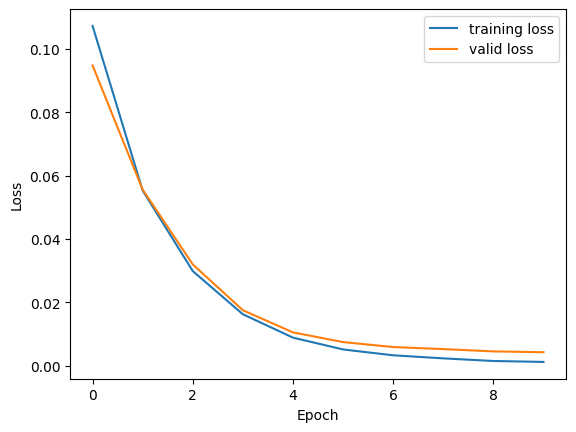

In [51]:
plot_losses(loss_dict)


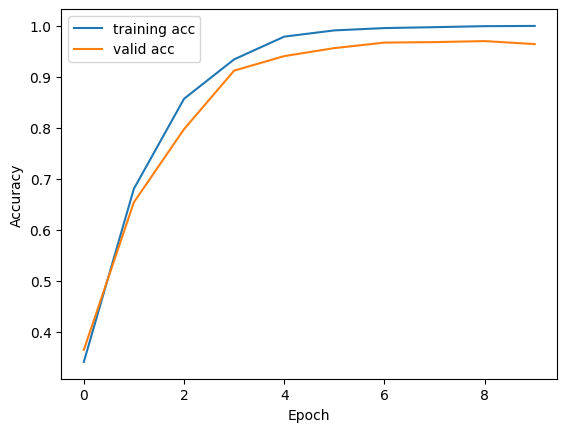

In [52]:
plot_acc(loss_dict)

Step 4: Test the Model

In [34]:
def test_model(model, test_dataloader, class2idx=None, plot_incorrect=False):


  model.eval()
  class2idx = class2idx if class2idx else test_dataloader.dataset.class_to_idx 
  idx2class = {class2idx[key]:key for key in class2idx}

  with torch.no_grad():
    for i, (data, target) in enumerate(test_dataloader):
      
      output = model(data).cpu().numpy()
      logits = output if i==0 else np.concatenate((logits, output), axis=0)  
      probs_batch = np.array([[np.exp(l)/sum(np.exp(batch)) for l in batch] for batch in output]) 
      probs = probs_batch if i==0 else np.concatenate((probs, probs_batch), axis=0)  
      preds_batch = np.argmax(output, axis=1)
      preds = preds_batch if i==0 else np.concatenate((preds, preds_batch), axis=0) 
      test_labels = target.numpy() if i==0 else np.concatenate((test_labels, target.numpy()), axis=0)    

      if plot_incorrect: 
        is_pred_correct = preds_batch==target.numpy()
        if 0 in is_pred_correct:
          for incorr_i in [j for j, val in enumerate(is_pred_correct) if val==0]:
            plt.imshow(np.transpose(data[incorr_i].cpu().numpy(), (1,2,0)))
            plt.title("True label: {}, Predicted label: {}".format(idx2class[target.numpy()[incorr_i]], idx2class[preds[incorr_i]]))
            plt.show()
  
  return preds, test_labels, logits, probs

In [35]:
preds, labels, logits, probs = test_model(model, dataloaders['test'], test_data.class_to_idx, plot_incorrect=False)

In [28]:


preds = np.array(preds) 
labels = np.array(labels)  


accuracy = accuracy_score(labels, preds)

precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')

conf_matrix = confusion_matrix(labels, preds)


print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.9686
Precision: 0.9716
Recall: 0.9686
F1 Score: 0.9686
Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 1  0  0 ...  7  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]


In [36]:
def classify_one_image(img_path, model, classes):  
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    img = transform(img)[:3, :, :].unsqueeze(0)  

  
    plt.imshow(np.transpose(img.squeeze(0).numpy(), (1, 2, 0)))
    plt.show()

    model.eval()

  
    with torch.no_grad():
        logits = model(img).cpu().detach().numpy() 
    probs = np.array([[np.exp(l) / sum(np.exp(batch)) for l in batch] for batch in logits]).squeeze(0)

    logits_df = pd.DataFrame(probs, index=classes, columns=["probability"]).sort_values("probability", ascending=False)
    
   
    predicted_class = logits_df.index[0]
    predicted_probability = logits_df.iloc[0, 0]

    print(f"Predicted class: {predicted_class} (Probability: {predicted_probability:.4f})")

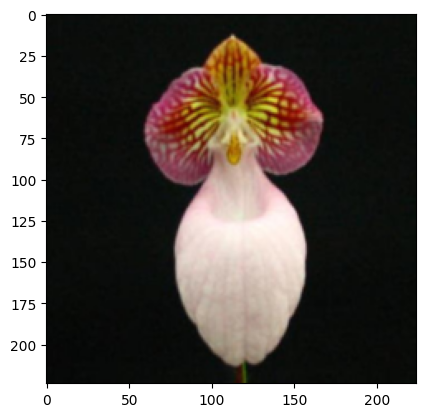

Predicted class: 2 (Probability: 0.9835)


In [37]:
classify_one_image(r"C:\Users\kavya\OneDrive\Desktop\Flower\data\102flowers\image_05142.jpg", model, train_data.classes)